In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# change the working directory to the Drive root
%cd /content/drive/My\ Drive

/content/drive/My Drive


In [5]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.5 MB/s eta 0:00:00


In [ ]:
import torch.nn as nn
import numpy as np

def glorot(value, name=None):
    """Glorot & Bengio (AISTATS 2010) init."""
    init_range = np.sqrt(6.0 / (value.size(-2) + value.size(-1)))
    initial = value.data.uniform_(-init_range, init_range)
    return nn.Parameter(initial, requires_grad=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import softmax, scatter


class GATLayer(nn.Module):

  def __init__(self,
               D_in: int,
               D_out: int,
               num_heads: int = 1,
               act=F.elu,
               dropout: float = 0.0,
               reduce='none',
               skip=False):
    super().__init__()
    self.D_in = D_in
    self.D_out = D_out
    self.N_h = num_heads
    self.act = act

    self.W = nn.Parameter(torch.zeros((num_heads, D_out, D_in)))
    self.W_skip = nn.Parameter(torch.zeros((num_heads, D_out, D_in)))
    self.A_src = nn.Parameter(torch.zeros((num_heads, D_out, 1)))
    self.A_tgt = nn.Parameter(torch.zeros((num_heads, D_out, 1)))

    self.reduce = reduce
    self.dropout = dropout
    self.skip = skip

    self.reset_parameters()

  def reset_parameters(self):
    glorot(self.W)
    glorot(self.W_skip)
    glorot(self.A_src)
    glorot(self.A_tgt)


  def forward(self, H_in: torch.tensor, edge_index: torch.tensor) -> torch.tensor:
    #edge_src = edge_index[:1].t().squeeze()
    #edge_tgt = edge_index[1:].t().squeeze()
    edge_src, edge_tgt = edge_index

    N, _ = H_in.shape
    W = self.W
    W_skip = self.W_skip

    A_src = self.A_src
    A_tgt = self.A_tgt
    D_in = self.D_in
    D_out = self.D_out
    N_h = self.N_h
    act = self.act
    dropout = self.dropout
    training = self.training
    skip = self.skip

    W = W.view((N_h, D_out, D_in))
    W_skip = W.view((N_h, D_out, D_in))

    A_src = A_src.view((N_h, D_out))
    A_tgt = A_tgt.view((N_h, D_out))

    H_in = F.dropout(H_in, dropout, training)

    # H_w = torch.einsum('ij, nkj -> nik', H_in, W)  # (N_h, |V|, D_out)
    # H_w = torch.matmul(H_in, W.transpose(1, 2)) # works too!
    H_w = torch.matmul(H_in, W.permute(0, 2, 1)) # works too!

    H_w = F.dropout(H_w, dropout, training)  # (N_h, |V|, D_out)

    # H_w_src = torch.index_select(H_w, 1, edge_src)  # (N_h, |E|, D_out)
    # H_w_tgt = torch.index_select(H_w, 1, edge_tgt)  # (N_h, |E|, D_out)
    H_w_src = H_w[:, edge_src]
    H_w_tgt = H_w[:, edge_tgt]

    # E_pre_src = torch.einsum('nij, nj -> ni', H_w_src, A_src)  # (N_h, |E|, 1), a_src^T Whi
    # E_pre_tgt = torch.einsum('nij, nj -> ni', H_w_tgt, A_tgt)  # (N_h, |E|, 1), a_tgt^T Whj
    E_pre_src = torch.matmul(H_w_src, A_src.unsqueeze(-1)).squeeze()
    E_pre_tgt = torch.matmul(H_w_tgt, A_tgt.unsqueeze(-1)).squeeze()

    E_pre = E_pre_src + E_pre_tgt  # (N_h, |E|, 1), a^T [Whi || Whj]
    E = F.leaky_relu(E_pre, negative_slope=0.2)  # (N_h, |E|, 1), LeakyRelu(a^T [Whi || Whj])

    alpha_scores = softmax(E, edge_tgt, dim=1).view((N_h, *edge_src.shape, 1))  # (N_h, |E|, 1)
    # Manually implement softmax
    # alpha_scores = torch.exp(E - torch.max(E, dim=1, keepdim=True)[0])

    alpha_scores = F.dropout(alpha_scores, dropout, training)
    Alpha = alpha_scores.repeat(1, 1, D_out)  # (N_h, |E|, D_out)

    self.attention_scores = alpha_scores

    H_out_pre = scatter(Alpha * H_w_src, edge_tgt, dim=1, reduce='sum')  # (N_h, |V|, D_out)

    if skip:
      H_skip_to_add = torch.zeros_like(H_out_pre)
      if D_in != D_out:
        # H_skip : (|V|, D_in)
        # W_skip : (N_h, D_out, D_in)
        # H_skip_add : (N_h, |V|, D_out)
        # H_skip_to_add = torch.einsum('ij, nkj -> nik', H_in, W_skip)
        H_skip_to_add = torch.matmul(H_in, W_skip.transpose(1, 2))
      else:
        # H_skip_add : (N_h, |V|, D_out)
        H_skip_to_add = H_in.repeat(N_h, 1, 1)

      H_out_pre += H_skip_to_add

    if self.reduce == 'none':
      H_out = act(H_out_pre)  # (N_h, |V|, D_out)
      assert (H_out.shape == (N_h, N, D_out))
      return H_out
    elif self.reduce == 'concat':
      H_out = act(H_out_pre)
      H_out_per_head = torch.tensor_split(H_out, N_h)
      H_out_cat = torch.cat(H_out_per_head, dim=-1).squeeze()
      self.embeddings = H_out_cat
      assert (H_out_cat.shape == (N, N_h * D_out))
      return H_out_cat
    else:
      H_out_pre_avg = torch.mean(H_out_pre, dim=0)
      H_out = act(H_out_pre_avg)
      self.embeddings = H_out
      assert (H_out.shape == (N, D_out))
      return H_out

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# evaluate
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
import numpy as np

def evaluate(model, batch_loader):
    model = model.to(device)

    loss_fcn = nn.BCEWithLogitsLoss()

    total_score = 0
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for (batch_id, batched_graph) in enumerate(batch_loader):
            node_features = batched_graph.x.to(device)
            edge_index = batched_graph.edge_index.to(device)
            labels = batched_graph.y.to(device)

            logits = model(node_features, edge_index)
            pred = (logits >= 0).float().cpu().numpy() # torch.where(logits >= 0, 1, 0)
            loss = loss_fcn(logits, labels)
            score = torch.tensor(f1_score(labels.cpu().numpy(), pred, average='micro'), dtype=torch.float32, device=device) #

        total_loss += loss.item()
        total_score += score.item()

    avg_loss = total_loss / (batch_id + 1)
    avg_score = total_score / (batch_id + 1)

    return avg_loss, avg_score

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F



class GAT_PPI(nn.Module):

  def __init__(self, dim_in: int, num_classes: int):
    super().__init__()
    self.model_name = 'GAT_PPI'
    # assumes self loops were added by dataset transform
    self.layers = nn.ModuleList([
        GATLayer(dim_in, 256, 4, act=F.elu, reduce='concat'),
        GATLayer(1024, 256, 4, act=F.elu, reduce='concat', skip=True),
        GATLayer(1024, num_classes, 6, act=nn.Identity(), reduce='avg', skip=True)
    ])
    self.reset_parameters()

  def forward(self, X: torch.tensor, edge_index: torch.tensor) -> torch.tensor:
    out = X
    for layer in self.layers:
      out = layer(out, edge_index)
    return out

  def reset_parameters(self):
    for layer in self.layers:
      layer.reset_parameters()

In [ ]:
# train
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
import numpy as np


def train(model, params: dict, verbose: bool = True) -> torch.nn.Module:
    print('training model {}'.format(params['model_name']))
    print(model)
    print('training...')

    optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    model.reset_parameters()
    batch_criterion = nn.BCEWithLogitsLoss()

    best_f1 = -1
    best_loss = pow(10, 9)
    patience = params['patience']
    underperformed = 0

    train_losses, train_scores = [], []
    val_losses, val_scores = [], []

    best_model_state_dict = None
    best_optimizer_state_dict = None
    best_epoch = 0

    for epoch in range(params['epochs']):
        if underperformed >= patience:
            print('early stopping...')
            break

        model.train()
        total_train_loss = 0
        total_train_score = 0

        for (batch_ix, batch) in enumerate(train_loader):
            node_features, edge_index, labels = (batch.x.to(device), batch.edge_index.to(device), batch.y.to(device))

            optimizer.zero_grad()
            logits = model(node_features, edge_index)
            pred = torch.where(logits >= 0, 1, 0)
            loss = batch_criterion(logits, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            pred_np = pred.cpu().numpy()
            labels_np = labels.cpu().numpy()
            f1 = f1_score(labels_np, pred_np, average='micro')
            total_train_score += torch.tensor(f1, dtype=torch.float32, device=device).item()

        avg_train_loss = total_train_loss / (batch_ix + 1)
        avg_train_score = total_train_score / (batch_ix + 1)

        val_loss, val_score = evaluate(model, val_loader)

        train_losses.append(avg_train_loss)
        train_scores.append(avg_train_loss)
        val_losses.append(val_loss)
        val_scores.append(val_score)

        if (val_score > best_f1 or val_loss < best_loss):
            best_f1 = max(best_f1, val_score)
            best_loss = min(best_loss, val_loss)
            underperformed = 0
            was_best_so_far = True
            best_model_state_dict = model.state_dict()
            best_optimizer_state_dict = optimizer.state_dict()
            best_epoch = epoch
        else:
            underperformed += 1
            was_best_so_far = False

        if was_best_so_far:
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_model_state_dict,
                'optimizer_state_dict': best_optimizer_state_dict,
            }, params['model_name'])

        if verbose:
            print('epoch {:05d}'.format(epoch + 1))
            print('\t{}_loss: {:.4f} | {}_micro_f1: {:.4f}'.format('train', avg_train_loss,'train', avg_train_score))
            print('\t{}_loss: {:.4f} | {}_micro_f1: {:.4f}'.format('val', val_loss,'val', val_score))

    state = torch.load(params['model_name'])
    model.load_state_dict(state['model_state_dict'])
    model.eval()

    best_epoch, best_model = state['epoch'], model
    best_val_loss, best_val_score = evaluate(model, val_loader)
    best_test_loss, best_test_score = evaluate(model, test_loader)

    print('best model performance @ epoch {:05d}: '.format(best_epoch))
    print('\t{}_loss: {:.4f} | {}_micro_f1: {:.4f}'.format('val', best_val_loss, 'val', best_val_score))
    print('\t{}_loss: {:.4f} | {}_micro_f1: {:.4f}'.format('test', best_test_loss,'test', best_test_score))

    return best_model, train_losses, train_scores, val_losses, val_scores


In [ ]:
import torch
import random

random.seed(42)
torch.manual_seed(42)

In [ ]:
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import AddSelfLoops

train_dataset = PPI(root='', split='train', transform=AddSelfLoops())
val_dataset = PPI(root='', split='val', transform=AddSelfLoops())
test_dataset = PPI(root='', split='test', transform=AddSelfLoops())

num_features = 50
num_labels = 121
train_loader = DataLoader(train_dataset, batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

In [ ]:
model = GAT_PPI(num_features, num_labels)
# evaluate(model, test_loader)

Demonstate the evaluation function

In [ ]:
evaluate(model, test_loader)

(0.7045281529426575, 0.3901699185371399)

Demonstate the train function:

- If you run this using Google Hardware accelerator T4 GPU, then just set the epochs to 2 or 3, , from my testing it will cost less than 2 mintues.
- If you run this using Google Hardware accelerator CPU, then just set the epochs to 1, from my testing it will cost aproxmately 8 mintues.

In [ ]:
ppi_train_params_demo = {
  "lr": 5e-3,
  "weight_decay": 0,
  "epochs": 3,
  "patience": 100,
  "model_name": model.model_name
}

In [ ]:
best_model,_ ,_ ,_ ,_ = train(model, ppi_train_params_demo)

training model GAT_PPI
GAT_PPI(
  (layers): ModuleList(
    (0-1): 2 x GATLayer()
    (2): GATLayer(
      (act): Identity()
    )
  )
)
training...
epoch 00001
	train_loss: 0.7525 | train_micro_f1: 0.4247
	val_loss: 0.5892 | val_micro_f1: 0.4316
epoch 00002
	train_loss: 0.5561 | train_micro_f1: 0.4739
	val_loss: 0.5164 | val_micro_f1: 0.5011
epoch 00003
	train_loss: 0.5177 | train_micro_f1: 0.4984
	val_loss: 0.5001 | val_micro_f1: 0.4951
best model performance @ epoch 00002: 
	val_loss: 0.5001 | val_micro_f1: 0.4951
	test_loss: 0.5004 | test_micro_f1: 0.5033


In [ ]:
ppi_train_params = {
  "lr": 5e-3,
  "weight_decay": 0,
  "epochs": 200,
  "patience": 100,
  "model_name": model.model_name
}

In [ ]:
best_model, train_losses, train_scores, val_losses, val_scores = train(model, ppi_train_params)
# best_model = model
# model_saver.download_best_model_state()

training model GAT_PPI
GAT_PPI(
  (layers): ModuleList(
    (0-1): 2 x GATLayer()
    (2): GATLayer(
      (act): Identity()
    )
  )
)
training...
epoch 00001
	train_loss: 0.7107 | train_micro_f1: 0.4231
	val_loss: 0.5889 | val_micro_f1: 0.4715
epoch 00002
	train_loss: 0.5649 | train_micro_f1: 0.4704
	val_loss: 0.5278 | val_micro_f1: 0.4548
epoch 00003
	train_loss: 0.5263 | train_micro_f1: 0.4894
	val_loss: 0.5038 | val_micro_f1: 0.4694
epoch 00004
	train_loss: 0.5089 | train_micro_f1: 0.5098
	val_loss: 0.4918 | val_micro_f1: 0.5014
epoch 00005
	train_loss: 0.4954 | train_micro_f1: 0.5326
	val_loss: 0.4842 | val_micro_f1: 0.5005
epoch 00006
	train_loss: 0.4843 | train_micro_f1: 0.5526
	val_loss: 0.4717 | val_micro_f1: 0.5428
epoch 00007
	train_loss: 0.4784 | train_micro_f1: 0.5651
	val_loss: 0.4690 | val_micro_f1: 0.5764
epoch 00008
	train_loss: 0.4661 | train_micro_f1: 0.5865
	val_loss: 0.4620 | val_micro_f1: 0.5312
epoch 00009
	train_loss: 0.4614 | train_micro_f1: 0.5891
	val_loss:

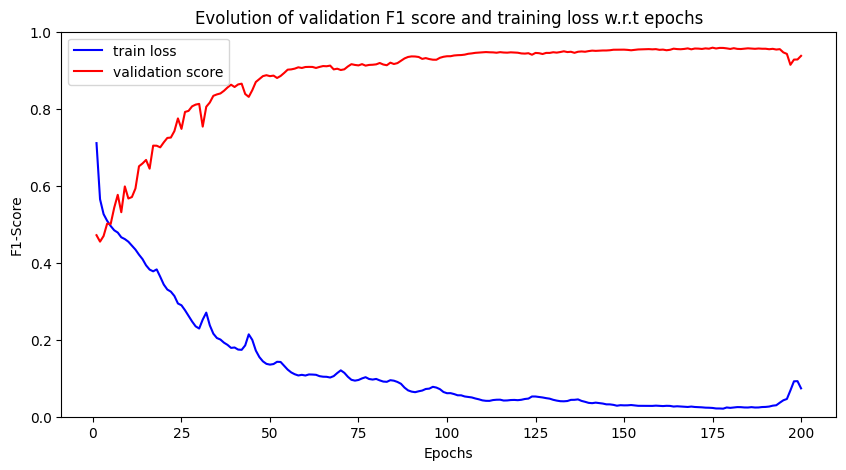

In [ ]:
import matplotlib.pyplot as plt
#train_losses, train_scores, val_losses, val_scores
def plot_f1_score(epoch_list, train_losses, val_scores):
    plt.figure(figsize = [10,5])
    plt.plot(epoch_list, train_losses, 'b', label = "train loss")
    plt.plot(epoch_list, val_scores, 'r', label = "validation score")
    plt.title("Evolution of validation F1 score and training loss w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.xlabel("Epochs")
    plt.ylabel("F1-Score")
    plt.legend()
    plt.savefig('/content/drive/My Drive/GAT_ppi_200_epoch.png')
    plt.show()


epoch_list = list(range(1, 201))
plot_f1_score(epoch_list, train_losses, val_scores)


In [ ]:
def run_inductive_experiment(iters=10):
  losses = []
  scores = []
  for iter in range(iters):
    best_model,_ ,_ ,_ ,_ = train(model, ppi_train_params, verbose=False)
    loss, score = evaluate(best_model, test_loader)
    losses.append(loss)
    scores.append(score)
  losses = torch.tensor(losses)
  scores = torch.tensor(scores)
  return (torch.std_mean(losses), torch.std_mean(scores))

Colab's free version works on a dynamic usage limit, which is not fixed and size is not documented anywhere, that is the reason free version is not a guaranteed and unlimited resources.
Basically, the overall usage limits and timeout periods, maximum VM lifetime, GPU types available, and other factors vary over time. Colab does not publish these limits, in part because they can (and sometimes do) vary quickly.

GPUs and TPUs are sometimes prioritized for users who use Colab interactively rather than for long-running computations, or for users who have recently used less resources in Colab. As a result, users who use Colab for long-running computations, or users who have recently used more resources in Colab, are more likely to run into usage limits and have their access to GPUs and TPUs temporarily restricted.

It suppose to directly run in 10 iterations at one go. However, Due to the usage limits in Google colab, it never let me run 10 iterations on one go, it always stop at aroung # 5, 6 iteration and it really require at least 12+ GPU. I decided to run it 2 iterations for 5 times.

In [ ]:
loss_ci, score_ci = run_inductive_experiment(10)

Demonstate the experiment function

In [ ]:
loss_ci_0, score_ci_0 = run_inductive_experiment(2)

training model GAT_PPI
GAT_PPI(
  (layers): ModuleList(
    (0-1): 2 x GATLayer()
    (2): GATLayer(
      (act): Identity()
    )
  )
)
training...
best model performance @ epoch 00183: 
	val_loss: 0.1116 | val_micro_f1: 0.9589
	test_loss: 0.0619 | test_micro_f1: 0.9765
training model GAT_PPI
GAT_PPI(
  (layers): ModuleList(
    (0-1): 2 x GATLayer()
    (2): GATLayer(
      (act): Identity()
    )
  )
)
training...
best model performance @ epoch 00178: 
	val_loss: 0.1121 | val_micro_f1: 0.9563
	test_loss: 0.0638 | test_micro_f1: 0.9735


In [ ]:
loss_ci_1, score_ci_1 = run_inductive_experiment(2)

training model GAT_PPI
GAT_PPI(
  (layers): ModuleList(
    (0-1): 2 x GATLayer()
    (2): GATLayer(
      (act): Identity()
    )
  )
)
training...
best model performance @ epoch 00182: 
	val_loss: 0.0994 | val_micro_f1: 0.9627
	test_loss: 0.0563 | test_micro_f1: 0.9773
training model GAT_PPI
GAT_PPI(
  (layers): ModuleList(
    (0-1): 2 x GATLayer()
    (2): GATLayer(
      (act): Identity()
    )
  )
)
training...
best model performance @ epoch 00192: 
	val_loss: 0.1055 | val_micro_f1: 0.9593
	test_loss: 0.0717 | test_micro_f1: 0.9724


In [ ]:
loss_ci_2, score_ci_2 = run_inductive_experiment(2)

training model GAT_PPI
GAT_PPI(
  (layers): ModuleList(
    (0-1): 2 x GATLayer()
    (2): GATLayer(
      (act): Identity()
    )
  )
)
training...
best model performance @ epoch 00173: 
	val_loss: 0.1063 | val_micro_f1: 0.9602
	test_loss: 0.0623 | test_micro_f1: 0.9751
training model GAT_PPI
GAT_PPI(
  (layers): ModuleList(
    (0-1): 2 x GATLayer()
    (2): GATLayer(
      (act): Identity()
    )
  )
)
training...
best model performance @ epoch 00197: 
	val_loss: 0.1047 | val_micro_f1: 0.9626
	test_loss: 0.0619 | test_micro_f1: 0.9761


In [ ]:
loss_ci_3, score_ci_3 = run_inductive_experiment(2)

training model GAT_PPI
GAT_PPI(
  (layers): ModuleList(
    (0-1): 2 x GATLayer()
    (2): GATLayer(
      (act): Identity()
    )
  )
)
training...
best model performance @ epoch 00172: 
	val_loss: 0.1069 | val_micro_f1: 0.9577
	test_loss: 0.0622 | test_micro_f1: 0.9745
training model GAT_PPI
GAT_PPI(
  (layers): ModuleList(
    (0-1): 2 x GATLayer()
    (2): GATLayer(
      (act): Identity()
    )
  )
)
training...
best model performance @ epoch 00197: 
	val_loss: 0.1104 | val_micro_f1: 0.9608
	test_loss: 0.0632 | test_micro_f1: 0.9770


In [ ]:
loss_ci_4, score_ci_4 = run_inductive_experiment(2)

training model GAT_PPI
GAT_PPI(
  (layers): ModuleList(
    (0-1): 2 x GATLayer()
    (2): GATLayer(
      (act): Identity()
    )
  )
)
training...
best model performance @ epoch 00170: 
	val_loss: 0.1057 | val_micro_f1: 0.9575
	test_loss: 0.0618 | test_micro_f1: 0.9740
training model GAT_PPI
GAT_PPI(
  (layers): ModuleList(
    (0-1): 2 x GATLayer()
    (2): GATLayer(
      (act): Identity()
    )
  )
)
training...
best model performance @ epoch 00199: 
	val_loss: 0.1042 | val_micro_f1: 0.9620
	test_loss: 0.0639 | test_micro_f1: 0.9751


Below is the code for print the loss and f1 score however due to the previous running problem it never got chance to run.

In [ ]:
loss_std, loss_mean = loss_ci
score_std, score_mean = score_ci

print(f'loss:\t\t{loss_mean:.4f} +/- {loss_std:.4f}')
print(f'micro F1 score: {score_mean:.4f} +/- {score_std:.4f}')

Modify above code so it can use the 5 results together.

In [ ]:
loss_std, loss_mean = torch.std_mean(torch.tensor([ 0.0619, 0.0638, 0.0563, 0.0717, 0.0623, 0.0619, 0.0622, 0.0632, 0.0618, 0.0639 ]))
score_std, score_mean = torch.std_mean(torch.tensor([ 0.9765, 0.9735, 0.9773, 0.9724, 0.9751, 0.9761, 0.9745, 0.9770, 0.9740, 0.9751]))

print(f'test loss:\t\t{loss_mean:.4f} +/- {loss_std:.4f}')
print(f'test micro F1 score: \t{score_mean:.4f} +/- {score_std:.4f}')

test loss:		0.0629 +/- 0.0038
test micro F1 score: 	0.9751 +/- 0.0016


In [ ]:
from IPython.display import display, HTML
import pandas as pd

df = pd.DataFrame({'Iteration #' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'Mean', 'Standard Deviation'],
                   'GAT PPI Test Loss' : [ 0.0619, 0.0638, 0.0563, 0.0717, 0.0623, 0.0619, 0.0622, 0.0632, 0.0618, 0.0639, loss_mean.item(), loss_std.item() ],
                   'GAT PPI Test Accuracy' : [0.9765, 0.9735, 0.9773, 0.9724, 0.9751, 0.9761, 0.9745, 0.9770, 0.9740, 0.9751, score_mean.item(), score_std.item()]})
#display(df)
display(HTML(df.to_html(index=False)))

In [6]:
import torch
from torch import nn
import torch.nn.functional as F


################################
###       GAT LAYER # 1      ###
################################

class GraphAttentionLayer(nn.Module):
    """
    Graph Attention Layer (GAT) as described in the paper `"Graph Attention Networks" <https://arxiv.org/pdf/1710.10903.pdf>`.

        This operation can be mathematically described as:

            e_ij = a(W h_i, W h_j)
            α_ij = softmax_j(e_ij) = exp(e_ij) / Σ_k(exp(e_ik))
            h_i' = σ(Σ_j(α_ij W h_j))

            where h_i and h_j are the feature vectors of nodes i and j respectively, W is a learnable weight matrix,
            a is an attention mechanism that computes the attention coefficients e_ij, and σ is an activation function.

    """
    def __init__(self, in_features: int, out_features: int, n_heads: int, concat: bool = False, dropout: float = 0.4, leaky_relu_slope: float = 0.2):
        super(GraphAttentionLayer, self).__init__()

        self.n_heads = n_heads # Number of attention heads
        self.concat = concat # wether to concatenate the final attention heads
        self.dropout = dropout # Dropout rate

        if concat: # concatenating the attention heads
            self.out_features = out_features # Number of output features per node
            assert out_features % n_heads == 0 # Ensure that out_features is a multiple of n_heads
            self.n_hidden = out_features // n_heads
        else: # averaging output over the attention heads (Used in the main paper)
            self.n_hidden = out_features

        #  A shared linear transformation, parametrized by a weight matrix W is applied to every node
        #  Initialize the weight matrix W
        self.W = nn.Parameter(torch.empty(size=(in_features, self.n_hidden * n_heads)))

        # Initialize the attention weights a
        self.a = nn.Parameter(torch.empty(size=(n_heads, 2 * self.n_hidden, 1)))

        self.leakyrelu = nn.LeakyReLU(leaky_relu_slope) # LeakyReLU activation function
        self.softmax = nn.Softmax(dim=1) # softmax activation function to the attention coefficients

        self.reset_parameters() # Reset the parameters


    def reset_parameters(self):
        """
        Reinitialize learnable parameters.
        """
        nn.init.xavier_normal_(self.W)
        nn.init.xavier_normal_(self.a)


    def forward(self,  h: torch.Tensor, adj_mat: torch.Tensor):
        """
        Performs a graph attention layer operation.

        Args:
            h (torch.Tensor): Input tensor representing node features.
            adj_mat (torch.Tensor): Adjacency matrix representing graph structure.

        Returns:
            torch.Tensor: Output tensor after the graph convolution operation.
        """
        n_nodes = h.shape[0]

        # Apply linear transformation to node feature -> W h
        # output shape (n_nodes, n_hidden * n_heads)
        h_transformed = torch.mm(h, self.W)
        h_transformed = F.dropout(h_transformed, self.dropout, training=self.training)

        # splitting the heads by reshaping the tensor and putting heads dim first
        # output shape (n_heads, n_nodes, n_hidden)
        h_transformed = h_transformed.view(n_nodes, self.n_heads, self.n_hidden).permute(1, 0, 2)

        # getting the attention scores
        # output shape (n_heads, n_nodes, n_nodes)
        # e = self._get_attention_scores(h_transformed) ORGINIAL
        source_scores = torch.matmul(h_transformed, self.a[:, :self.n_hidden, :])
        target_scores = torch.matmul(h_transformed, self.a[:, self.n_hidden:, :])

        # broadcast add
        # (n_heads, n_nodes, 1) + (n_heads, 1, n_nodes) = (n_heads, n_nodes, n_nodes)
        e = source_scores + target_scores.mT
        e = self.leakyrelu(e)

        # Set the attention score for non-existent edges to -9e15 (MASKING NON-EXISTENT EDGES)
        connectivity_mask = -9e16 * torch.ones_like(e)
        e = torch.where(adj_mat > 0, e, connectivity_mask) # masked attention scores

        # attention coefficients are computed as a softmax over the rows
        # for each column j in the attention score matrix e
        attention = F.softmax(e, dim=-1)
        attention = F.dropout(attention, self.dropout, training=self.training)

        # final node embeddings are computed as a weighted average of the features of its neighbors
        h_prime = torch.matmul(attention, h_transformed)

        # concatenating/averaging the attention heads
        # output shape (n_nodes, out_features)
        if self.concat:
            h_prime = h_prime.permute(1, 0, 2).contiguous().view(n_nodes, self.out_features)
        else:
            h_prime = h_prime.mean(dim=0)

        return h_prime

In [7]:
import torch
from torch import nn
import torch.nn.functional as F

################################
###    GAT NETWORK MODULE    ###
################################

class GAT(nn.Module):
    """
    Graph Attention Network (GAT) as described in the paper `"Graph Attention Networks" <https://arxiv.org/pdf/1710.10903.pdf>`.
    Consists of a 2-layer stack of Graph Attention Layers (GATs). The fist GAT Layer is followed by an ELU activation.
    And the second (final) layer is a GAT layer with a single attention head and softmax activation function.
    """
    def __init__(self,
        in_features,
        n_hidden,
        n_heads,
        num_classes,
        concat=False,
        dropout=0.4,
        leaky_relu_slope=0.2):
        """ Initializes the GAT model.

        Args:
            in_features (int): number of input features per node.
            n_hidden (int): output size of the first Graph Attention Layer.
            n_heads (int): number of attention heads in the first Graph Attention Layer.
            num_classes (int): number of classes to predict for each node.
            concat (bool, optional): Wether to concatinate attention heads or take an average over them for the
                output of the first Graph Attention Layer. Defaults to False.
            dropout (float, optional): dropout rate. Defaults to 0.4.
            leaky_relu_slope (float, optional): alpha (slope) of the leaky relu activation. Defaults to 0.2.
        """

        super(GAT, self).__init__()

        # Define the Graph Attention layers
        self.gat1 = GraphAttentionLayer(
            in_features=in_features, out_features=n_hidden, n_heads=n_heads,
            concat=concat, dropout=dropout, leaky_relu_slope=leaky_relu_slope
            )

        self.gat2 = GraphAttentionLayer(
            in_features=n_hidden, out_features=num_classes, n_heads=1,
            concat=False, dropout=dropout, leaky_relu_slope=leaky_relu_slope
            )


    '''
    def reset_parameters(self):
        self.gat1.reset_parameters()
        self.gat2.reset_parameters()
    '''

    def forward(self, input_tensor: torch.Tensor , adj_mat: torch.Tensor):
        """
        Performs a forward pass through the network.

        Args:
            input_tensor (torch.Tensor): Input tensor representing node features.
            adj_mat (torch.Tensor): Adjacency matrix representing graph structure.

        Returns:
            torch.Tensor: Output tensor after the forward pass.
        """

        # Apply the first Graph Attention layer
        x = self.gat1(input_tensor, adj_mat)
        x = F.elu(x) # Apply ELU activation function to the output of the first layer

        # Apply the second Graph Attention layer
        x = self.gat2(x, adj_mat)

        return F.log_softmax(x, dim=1) # Apply log softmax activation function

In [8]:
import os
import time
import requests
import tarfile
import numpy as np
import argparse

import torch

################################
### LOADING THE CORA DATASET ###
################################
def preprocess_index(cites_data, content_data):

    # Get unique IDs from both files
    content_ids = np.unique(content_data[:, 0])
    cites_ids = np.unique(np.concatenate((cites_data[:, 0], cites_data[:, 1])))

    # Create ID mappings
    content_id_mapping = dict(zip(content_ids, range(len(content_ids))))
    cites_id_mapping = {id: content_id_mapping.get(id, len(content_id_mapping) + idx) for idx, id in enumerate(np.setdiff1d(cites_ids, content_ids))}
    len_diff = len(cites_id_mapping)
    cites_id_mapping.update(content_id_mapping)

    # Update IDs in .cites file
    cites_data[:, 0] = [cites_id_mapping[id] for id in cites_data[:, 0]]
    cites_data[:, 1] = [cites_id_mapping[id] for id in cites_data[:, 1]]

    # Update IDs in .content file
    content_data[:, 0] = [content_id_mapping[id] for id in content_data[:, 0]]
    # Add len_diff rows to content_data
    additional_rows = np.zeros((len_diff, content_data.shape[1]),  dtype=content_data.dtype)
    additional_rows[:, 1:-1] = np.array([['0'] * (content_data.shape[1] - 2)] * len_diff)
    additional_rows[:, 0] = np.arange(len(content_ids), len(content_ids) + len_diff)
    additional_rows[:, -1] = np.array(['NONE'] * len_diff)

    new_content_data = np.vstack((content_data, additional_rows))

    return new_content_data, cites_data.astype(np.int64)

def load_data(path='./datasets/citeseer/', device='cpu'):
    """
    Loads the Cora dataset. The dataset is downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz.

    """

    # Set the paths to the data files
    content_path = os.path.join(path, 'citeseer.content')
    cites_path = os.path.join(path, 'citeseer.cites')

    # Load data from files
    content_data = np.genfromtxt(content_path, dtype=np.dtype(str))
    cites_data = np.genfromtxt(cites_path, dtype=np.dtype(str))

    content_tensor, cites_tensor = preprocess_index(cites_data, content_data)

    # Process features
    features = torch.FloatTensor(content_tensor[:, 1:-1].astype(np.int32)) # Extract feature values
    scale_vector = torch.sum(features, dim=1) # Compute sum of features for each node
    scale_vector = 1 / scale_vector # Compute reciprocal of the sums
    scale_vector[scale_vector == float('inf')] = 0 # Handle division by zero cases
    scale_vector = torch.diag(scale_vector).to_sparse() # Convert the scale vector to a sparse diagonal matrix
    features = scale_vector @ features # Scale the features using the scale vector

    # Process labels
    classes, labels = np.unique(content_tensor[:, -1], return_inverse=True) # Extract unique classes and map labels to indices
    labels = torch.LongTensor(labels) # Convert labels to a tensor

    # Process adjacency matrix
    idx = content_tensor[:, 0].astype(np.int32) # Extract node indices
    idx_map = {id: pos for pos, id in enumerate(idx)} # Create a dictionary to map indices to positions

    # Map node indices to positions in the adjacency matrix
    edges = np.array(
        list(map(lambda edge: [idx_map[edge[0]], idx_map[edge[1]]],
            cites_tensor)), dtype=np.int32)

    V = len(idx) # Number of nodes
    E = edges.shape[0] # Number of edges
    adj_mat = torch.sparse_coo_tensor(edges.T, torch.ones(E), (V, V), dtype=torch.int64) # Create the initial adjacency matrix as a sparse tensor
    adj_mat = torch.eye(V) + adj_mat # Add self-loops to the adjacency matrix

    # return features.to_sparse().to(device), labels.to(device), adj_mat.to_sparse().to(device)
    return features.to(device), labels.to(device), adj_mat.to(device)

In [64]:
# 3
import os
import time
import requests
import tarfile
import numpy as np
import argparse

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam

def train_and_evaluate(model, input, target, mask_train, mask_val, epochs, patience, print_result):
    optimizer = Adam(model.parameters(), lr=args['lr'], weight_decay=args['l2'])
    # model.to(device).reset_parameters()
    # model.reset_parameters()
    criterion = nn.NLLLoss()

    t_total = time.time()
    loss_values = []
    acc_values = []

    best_val_acc = 0.0
    best_val_loss = np.inf
    curr_step = 0

    best_model_state_dict = None
    best_optimizer_state_dict = None

    best = -1
    best_epoch = 0

    for epoch in range(epochs):
        # Configure the optimizer and loss function

        start_t = time.time()
        model.train()
        optimizer.zero_grad()

        # Forward pass
        output = model(*input)
        loss = criterion(output[mask_train], target[mask_train])  # Compute the loss using the training mask

        loss.backward()
        optimizer.step()

        # Evaluate the model performance on training and validation sets
        loss_train, acc_train = evaluate(model, criterion, input, target, mask_train)
        loss_val, acc_val = evaluate(model, criterion, input, target, mask_val)

        loss_values.append(loss_val)
        acc_values.append(acc_val)

        # Print the training progress
        if print_result:
            print(f'Epoch: {epoch + 1:04d} ({(time.time() - start_t):.4f}s) loss_train: {loss_train:.4f} acc_train: {acc_train:.4f} loss_val: {loss_val:.4f} acc_val: {acc_val:.4f}')

        if acc_val > best_val_acc or loss_val < best_val_loss:
            best_val_acc = max(acc_val, best_val_acc)
            best_val_loss = min(loss_val, best_val_loss)
            best_model_state_dict = model.state_dict()
            best_optimizer_state_dict = optimizer.state_dict()
            best_epoch = epoch
            curr_step = 0
            best_so_far = True
        else:
            curr_step += 1
            best_so_far = False

        if best_so_far:
            torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_state_dict,
                    'optimizer_state_dict': best_optimizer_state_dict,
                }, 'GAT')

        if curr_step == patience:
            print('Early stopping...')
            print(f'Best Val Loss: {best_val_loss:.4f}, Best Val Acc: {best_val_acc:.4f}')
            break

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    # Restore best model
    print('Loading {}th epoch'.format(best_epoch + 1))
    state = torch.load('GAT')
    model.load_state_dict(state['model_state_dict'])
    loss_test, acc_test = evaluate(model, criterion, (features, adj_mat), labels, idx_test)
    print(f'Test set results: loss {loss_test:.4f} accuracy {acc_test:.4f}')
    return model, loss_values, acc_values, loss_test, acc_test


def evaluate(model, criterion, input, target, mask):
    # model = model.to(device)
    model.eval()
    with torch.no_grad():
        output = model(*input)
        output, target = output[mask], target[mask]

        loss = criterion(output, target)
        acc = (output.argmax(dim=1) == target).float().sum() / len(target)

    return loss.item(), acc.item()


# Example usage
# Initialize your model, optimizer, criterion, input, target, and masks
# train(GAT_citeseer, optimizer, criterion, (features, adj_mat), labels, idx_train, idx_val, args['epochs'], args['patience'])

In [10]:
# 2
import torch
import os
import requests
import tarfile
import glob
# Set the parameters directly
args = {
    'seed': 42, # 9
    'no_cuda': False,
    'no_mps': False,
    'hidden_dim': 64,
    'num_heads': 8,
    'concat_heads': False,
    'dropout_p': 0.6,
    'lr': 0.005,
    'l2': 5e-4,
    'epochs': 200,  # 300
    'patience': 100,
    'print': True,
    # 'val_every': 20,
}

torch.manual_seed(args['seed'])
use_cuda = not args['no_cuda'] and torch.cuda.is_available()
use_mps = not args['no_mps'] and torch.backends.mps.is_available()

# Set the device to run on
if use_cuda:
    device = torch.device('cuda')
elif use_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} device')

Using cuda device


In [11]:
# Load the dataset
data_url = 'https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz'
path = './datasets/citeseer'

if os.path.isfile(os.path.join(path, 'citeseer.content')) and os.path.isfile(os.path.join(path, 'citeseer.cites')):
    print('Dataset already downloaded...')
else:
    print('Downloading dataset...')
    with requests.get(data_url, stream=True) as tgz_file:
        with tarfile.open(fileobj=tgz_file.raw, mode='r:gz') as tgz_object:
            tgz_object.extractall()

print('Loading dataset...')
# Load the dataset
features, labels, adj_mat = load_data(device=device)
# Split the dataset into training, validation, and test sets
idx = torch.randperm(len(labels)).to(device)
# idx_test, idx_val, idx_train = idx[:1200], idx[1200:1600], idx[1600:]
idx_test, idx_val, idx_train = idx[:1000], idx[1000:1500], idx[1500:]



Dataset already downloaded...
Loading dataset...


In [12]:
# Create the model
# The model consists of a 2-layer stack of Graph Attention Layers (GATs).
GAT_citeseer = GAT(
    in_features=features.shape[1],          # Number of input features per node
    n_hidden=args['hidden_dim'],            # Output size of the first Graph Attention Layer
    n_heads=args['num_heads'],               # Number of attention heads in the first Graph Attention Layer
    num_classes=labels.max().item() + 1,     # Number of classes to predict for each node
    concat=args['concat_heads'],             # Whether to concatenate attention heads
    dropout=args['dropout_p'],                # Dropout rate
    leaky_relu_slope=0.2                     # Alpha (slope) of the leaky ReLU activation
).to(device)

In [ ]:
# 3

best_model, loss_values, acc_values, loss_test, acc_test = train_and_evaluate(GAT_citeseer, (features, adj_mat), labels, idx_train, idx_val, args['epochs'], args['patience'], args['print'])

Epoch: 0001 (16.4478s) loss_train: 1.9420 acc_train: 0.5271 loss_val: 1.9424 acc_val: 0.5140
Epoch: 0002 (13.2491s) loss_train: 1.9379 acc_train: 0.6086 loss_val: 1.9388 acc_val: 0.5640
Epoch: 0003 (10.8165s) loss_train: 1.9339 acc_train: 0.6207 loss_val: 1.9353 acc_val: 0.5780
Epoch: 0004 (9.6499s) loss_train: 1.9298 acc_train: 0.6278 loss_val: 1.9317 acc_val: 0.5860
Epoch: 0005 (10.7097s) loss_train: 1.9255 acc_train: 0.6377 loss_val: 1.9279 acc_val: 0.5840
Epoch: 0006 (10.7778s) loss_train: 1.9212 acc_train: 0.6530 loss_val: 1.9241 acc_val: 0.6000
Epoch: 0007 (10.8381s) loss_train: 1.9170 acc_train: 0.6782 loss_val: 1.9204 acc_val: 0.6160
Epoch: 0008 (10.5602s) loss_train: 1.9128 acc_train: 0.6875 loss_val: 1.9166 acc_val: 0.6280
Epoch: 0009 (10.5469s) loss_train: 1.9086 acc_train: 0.6973 loss_val: 1.9129 acc_val: 0.6480
Epoch: 0010 (11.0695s) loss_train: 1.9043 acc_train: 0.7066 loss_val: 1.9092 acc_val: 0.6480
Epoch: 0011 (19.7382s) loss_train: 1.9001 acc_train: 0.7132 loss_val: 1

In [ ]:
#  DO NOT RUN THIS
loss_test, acc_test = evaluate(GAT_citeseer, criterion, (features, adj_mat), labels, idx_test)
print(f'Test set results: loss {loss_test:.4f} accuracy {acc_test:.4f}')
# Test set results: loss 1.6275 accuracy 0.7290

Test set results: loss 1.6275 accuracy 0.7290


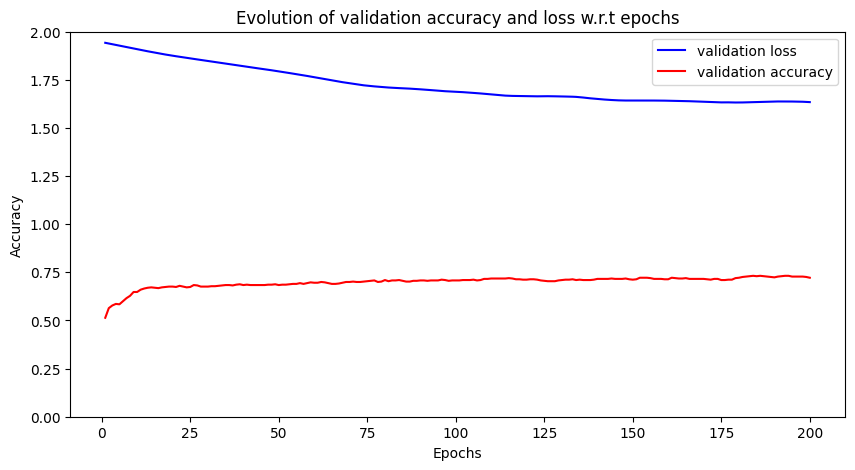

In [ ]:
import matplotlib.pyplot as plt
#train_losses, train_scores, val_losses, val_scores
def plot_accuracy(epoch_list, train_losses, val_scores):
    plt.figure(figsize = [10,5])
    plt.plot(epoch_list, train_losses, 'b', label = "validation loss")
    plt.plot(epoch_list, val_scores, 'r', label = "validation accuracy")
    plt.title("Evolution of validation accuracy and loss w.r.t epochs")
    plt.ylim([0.0, 2.0])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('/content/drive/My Drive/GAT_citeseer_200_epoch.png')
    plt.show()


epoch_list = list(range(1, 201))
plot_accuracy(epoch_list, loss_values, acc_values)

In [13]:
def run_transductive_experiment(iters=100):
  losses = []
  scores = []
  for iter in range(iters):
    #features, labels, adj_mat = load_data(device=device)
    #idx = torch.randperm(len(labels)).to(device)
    #idx_test, idx_val, idx_train = idx[:1000], idx[1000:1500], idx[1500:]
    best_model, loss_values, acc_values, loss_test, acc_test = train_and_evaluate(GAT_citeseer, (features, adj_mat), labels, idx_train, idx_val, args['epochs'], args['patience'], False)
    # best_model,_ ,_ ,_ ,_ = train(model, ppi_train_params, verbose=False)
    # loss, score = evaluate(best_model, test_loader)
    losses.append(loss_test)
    scores.append(acc_test)
  losses = torch.tensor(losses)
  scores = torch.tensor(scores)
  # return (torch.std_mean(losses), torch.std_mean(scores))
  return losses, scores

In [ ]:
losses, scores = run_transductive_experiment(2)

Early stopping...
Best Val Loss: 1.6196072101593018, Best Val Acc: 0.7300000190734863
Optimization Finished!
Total time elapsed: 1772.5080s
Loading 63th epoch
Test set results: loss 1.6147 accuracy 0.7230
Optimization Finished!
Total time elapsed: 2198.5439s
Loading 132th epoch
Test set results: loss 1.6199 accuracy 0.7230


In [14]:
losses_0, scores_0 = run_transductive_experiment(2)

Optimization Finished!
Total time elapsed: 44.3754s
Loading 194th epoch
Test set results: loss 1.6210 accuracy 0.7310
Early stopping...
Best Val Loss: 1.6216, Best Val Acc: 0.7320
Optimization Finished!
Total time elapsed: 20.0919s
Loading 50th epoch
Test set results: loss 1.6128 accuracy 0.7310


In [15]:
losses_1, scores_1 = run_transductive_experiment(2)

Early stopping...
Best Val Loss: 1.6219, Best Val Acc: 0.7380
Optimization Finished!
Total time elapsed: 22.7520s
Loading 91th epoch
Test set results: loss 1.6189 accuracy 0.7320
Early stopping...
Best Val Loss: 1.6299, Best Val Acc: 0.7420
Optimization Finished!
Total time elapsed: 11.8675s
Loading 1th epoch
Test set results: loss 1.6257 accuracy 0.7290


In [16]:
losses_2, scores_2 = run_transductive_experiment(2)

Early stopping...
Best Val Loss: 1.6324, Best Val Acc: 0.7380
Optimization Finished!
Total time elapsed: 14.8922s
Loading 17th epoch
Test set results: loss 1.6221 accuracy 0.7280
Early stopping...
Best Val Loss: 1.6272, Best Val Acc: 0.7300
Optimization Finished!
Total time elapsed: 26.8779s
Loading 92th epoch
Test set results: loss 1.6215 accuracy 0.7260


In [20]:
losses_3, scores_3 = run_transductive_experiment(2)

Early stopping...
Best Val Loss: 1.6324, Best Val Acc: 0.7400
Optimization Finished!
Total time elapsed: 17.2719s
Loading 33th epoch
Test set results: loss 1.6374 accuracy 0.7280
Optimization Finished!
Total time elapsed: 27.0879s
Loading 115th epoch
Test set results: loss 1.6254 accuracy 0.7230


In [21]:
losses_4, scores_4 = run_transductive_experiment(2)

Early stopping...
Best Val Loss: 1.6348, Best Val Acc: 0.7360
Optimization Finished!
Total time elapsed: 19.4610s
Loading 62th epoch
Test set results: loss 1.6278 accuracy 0.7270
Optimization Finished!
Total time elapsed: 24.9122s
Loading 198th epoch
Test set results: loss 1.6332 accuracy 0.7220


In [22]:
losses_5, scores_5 = run_transductive_experiment(2)

Optimization Finished!
Total time elapsed: 26.0711s
Loading 169th epoch
Test set results: loss 1.6277 accuracy 0.7180
Optimization Finished!
Total time elapsed: 25.1110s
Loading 166th epoch
Test set results: loss 1.6329 accuracy 0.7270


In [23]:
losses_6, scores_6 = run_transductive_experiment(2)

Early stopping...
Best Val Loss: 1.6380, Best Val Acc: 0.7360
Optimization Finished!
Total time elapsed: 16.2396s
Loading 31th epoch
Test set results: loss 1.6321 accuracy 0.7270
Optimization Finished!
Total time elapsed: 25.2433s
Loading 169th epoch
Test set results: loss 1.6329 accuracy 0.7270


In [24]:
losses_7, scores_7 = run_transductive_experiment(2)

Optimization Finished!
Total time elapsed: 26.2348s
Loading 120th epoch
Test set results: loss 1.6286 accuracy 0.7240
Optimization Finished!
Total time elapsed: 24.5503s
Loading 141th epoch
Test set results: loss 1.6281 accuracy 0.7320


In [25]:
losses_8, scores_8 = run_transductive_experiment(2)

Early stopping...
Best Val Loss: 1.6348, Best Val Acc: 0.7380
Optimization Finished!
Total time elapsed: 18.2400s
Loading 42th epoch
Test set results: loss 1.6341 accuracy 0.7240
Optimization Finished!
Total time elapsed: 25.8495s
Loading 150th epoch
Test set results: loss 1.6280 accuracy 0.7260


In [26]:
losses_9, scores_9 = run_transductive_experiment(2)

Early stopping...
Best Val Loss: 1.6358, Best Val Acc: 0.7360
Optimization Finished!
Total time elapsed: 17.0150s
Loading 42th epoch
Test set results: loss 1.6323 accuracy 0.7280
Optimization Finished!
Total time elapsed: 30.2767s
Loading 124th epoch
Test set results: loss 1.6283 accuracy 0.7190


In [17]:
losses_10, scores_10 = run_transductive_experiment(2)

Optimization Finished!
Total time elapsed: 24.1893s
Loading 187th epoch
Test set results: loss 1.6332 accuracy 0.7220
Early stopping...
Best Val Loss: 1.6354, Best Val Acc: 0.7340
Optimization Finished!
Total time elapsed: 19.7346s
Loading 46th epoch
Test set results: loss 1.6285 accuracy 0.7230


In [18]:
losses, scores = run_transductive_experiment(10)

Optimization Finished!
Total time elapsed: 25.3853s
Loading 126th epoch
Test set results: loss 1.6249 accuracy 0.7290
Optimization Finished!
Total time elapsed: 25.5544s
Loading 157th epoch
Test set results: loss 1.6336 accuracy 0.7330
Early stopping...
Best Val Loss: 1.6361, Best Val Acc: 0.7360
Optimization Finished!
Total time elapsed: 25.0489s
Loading 97th epoch
Test set results: loss 1.6267 accuracy 0.7320
Early stopping...
Best Val Loss: 1.6338, Best Val Acc: 0.7340
Optimization Finished!
Total time elapsed: 24.4906s
Loading 74th epoch
Test set results: loss 1.6395 accuracy 0.7230
Early stopping...
Best Val Loss: 1.6338, Best Val Acc: 0.7340
Optimization Finished!
Total time elapsed: 19.9166s
Loading 52th epoch
Test set results: loss 1.6273 accuracy 0.7320
Early stopping...
Best Val Loss: 1.6350, Best Val Acc: 0.7440
Optimization Finished!
Total time elapsed: 25.0692s
Loading 99th epoch
Test set results: loss 1.6290 accuracy 0.7200
Early stopping...
Best Val Loss: 1.6333, Best Va

In [ ]:
loss_std, loss_mean = torch.std_mean(losses )
score_std, score_mean = torch.std_mean(scores + scores_1 + scores_2 + scores_3 + scores_4 + scores_5 + scores_6 + scores_7 + scores_8 + scores_9 + scores_10)

print(f'test loss:\t\t{loss_mean:.4f} +/- {loss_std:.4f}')
print(f'test accuracy: \t{score_mean:.4f} +/- {score_std:.4f}')

In [ ]:
losses_citeseer_100, scores_citeseer_100 = run_transductive_experiment(100)

In [ ]:
loss_std_citeseer_100, loss_mean_citeseer_100 = torch.std_mean(losses_citeseer_100)
score_std_citeseer_100, score_mean_citeseer_100 = torch.std_mean(scores_citeseer_100)

print(f'test loss:\t\t{loss_mean_citeseer_100:.4f} +/- {loss_std_citeseer_100:.4f}')
print(f'test accuracy: \t{score_mean_citeseer_100:.4f} +/- {score_std_citeseer_100:.4f}')

In [53]:
import os
import time
import requests
import tarfile
import numpy as np
import argparse

import torch


def load_data(path='./datasets/cora/', device='cpu'):
    """
    Loads the Cora dataset. The dataset is downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz.

    """

    # Set the paths to the data files
    content_path = os.path.join(path, 'cora.content')
    cites_path = os.path.join(path, 'cora.cites')

    # Load data from files
    content_tensor = np.genfromtxt(content_path, dtype=np.dtype(str))
    cites_tensor = np.genfromtxt(cites_path, dtype=np.int32)


    # content_tensor, cites_tensor = preprocess_index(cites_data, content_data)

    # Process features
    features = torch.FloatTensor(content_tensor[:, 1:-1].astype(np.int32)) # Extract feature values
    scale_vector = torch.sum(features, dim=1) # Compute sum of features for each node
    scale_vector = 1 / scale_vector # Compute reciprocal of the sums
    scale_vector[scale_vector == float('inf')] = 0 # Handle division by zero cases
    scale_vector = torch.diag(scale_vector).to_sparse() # Convert the scale vector to a sparse diagonal matrix
    features = scale_vector @ features # Scale the features using the scale vector

    # Process labels
    classes, labels = np.unique(content_tensor[:, -1], return_inverse=True) # Extract unique classes and map labels to indices
    labels = torch.LongTensor(labels) # Convert labels to a tensor

    # Process adjacency matrix
    idx = content_tensor[:, 0].astype(np.int32) # Extract node indices
    idx_map = {id: pos for pos, id in enumerate(idx)} # Create a dictionary to map indices to positions

    # Map node indices to positions in the adjacency matrix
    edges = np.array(
        list(map(lambda edge: [idx_map[edge[0]], idx_map[edge[1]]],
            cites_tensor)), dtype=np.int32)

    V = len(idx) # Number of nodes
    E = edges.shape[0] # Number of edges
    adj_mat = torch.sparse_coo_tensor(edges.T, torch.ones(E), (V, V), dtype=torch.int64) # Create the initial adjacency matrix as a sparse tensor
    adj_mat = torch.eye(V) + adj_mat # Add self-loops to the adjacency matrix

    # return features.to_sparse().to(device), labels.to(device), adj_mat.to_sparse().to(device)
    return features.to(device), labels.to(device), adj_mat.to(device)

In [70]:
# Load the dataset
data_url = 'https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz'
path = './datasets/cora'

if os.path.isfile(os.path.join(path, 'cora.content')) and os.path.isfile(os.path.join(path, 'cora.cites')):
    print('Dataset already downloaded...')
else:
    print('Downloading dataset...')
    with requests.get(data_url, stream=True) as tgz_file:
        with tarfile.open(fileobj=tgz_file.raw, mode='r:gz') as tgz_object:
            tgz_object.extractall()

print('Loading dataset...')
# Load the dataset
features, labels, adj_mat = load_data(device=device)


Dataset already downloaded...
Loading dataset...


In [84]:
# Split the dataset into training, validation, and test sets
idx = torch.randperm(len(labels)).to(device)
idx_test, idx_val, idx_train = idx[:1200], idx[1200:1600], idx[1600:]
#idx_test, idx_val, idx_train = idx[:1000], idx[1000:1500], idx[1500:]

In [85]:
# 2
import torch
import os
import requests
import tarfile
import glob
# Set the parameters directly
args = {
    'seed': 42,
    'no_cuda': False,
    'no_mps': False,
    'hidden_dim': 64,
    'num_heads': 8,
    'concat_heads': False,
    'dropout_p': 0.6,
    'lr': 0.005,
    'l2': 5e-4,
    'epochs': 200,
    'patience': 100,
    'print': True,
}

torch.manual_seed(args['seed'])
use_cuda = not args['no_cuda'] and torch.cuda.is_available()
use_mps = not args['no_mps'] and torch.backends.mps.is_available()

# Set the device to run on
if use_cuda:
    device = torch.device('cuda')
elif use_mps:
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} device')

Using cuda device


In [66]:
# Create the model
# The model consists of a 2-layer stack of Graph Attention Layers (GATs).
GAT_cora = GAT(
    in_features=features.shape[1],          # Number of input features per node
    n_hidden=args['hidden_dim'],            # Output size of the first Graph Attention Layer
    n_heads=args['num_heads'],               # Number of attention heads in the first Graph Attention Layer
    num_classes=labels.max().item() + 1,     # Number of classes to predict for each node
    concat=args['concat_heads'],             # Whether to concatenate attention heads
    dropout=args['dropout_p'],                # Dropout rate
    leaky_relu_slope=0.2                     # Alpha (slope) of the leaky ReLU activation
).to(device)

In [86]:
best_model, loss_values, acc_values, loss_test, acc_test = train_and_evaluate(GAT_cora, (features, adj_mat), labels, idx_train, idx_val, args['epochs'], args['patience'], args['print'])

Epoch: 0001 (0.0914s) loss_train: 1.4804 acc_train: 0.8547 loss_val: 1.4856 acc_val: 0.8450
Epoch: 0002 (0.0906s) loss_train: 1.4794 acc_train: 0.8457 loss_val: 1.4893 acc_val: 0.8425
Epoch: 0003 (0.0861s) loss_train: 1.4786 acc_train: 0.8475 loss_val: 1.4926 acc_val: 0.8325
Epoch: 0004 (0.0752s) loss_train: 1.4771 acc_train: 0.8520 loss_val: 1.4953 acc_val: 0.8300
Epoch: 0005 (0.0751s) loss_train: 1.4756 acc_train: 0.8601 loss_val: 1.4979 acc_val: 0.8300
Epoch: 0006 (0.0759s) loss_train: 1.4739 acc_train: 0.8601 loss_val: 1.4997 acc_val: 0.8225
Epoch: 0007 (0.0755s) loss_train: 1.4725 acc_train: 0.8628 loss_val: 1.5017 acc_val: 0.8175
Epoch: 0008 (0.0754s) loss_train: 1.4715 acc_train: 0.8664 loss_val: 1.5036 acc_val: 0.8200
Epoch: 0009 (0.0750s) loss_train: 1.4702 acc_train: 0.8700 loss_val: 1.5053 acc_val: 0.8125
Epoch: 0010 (0.0755s) loss_train: 1.4686 acc_train: 0.8745 loss_val: 1.5064 acc_val: 0.8050
Epoch: 0011 (0.0753s) loss_train: 1.4666 acc_train: 0.8782 loss_val: 1.5067 acc_

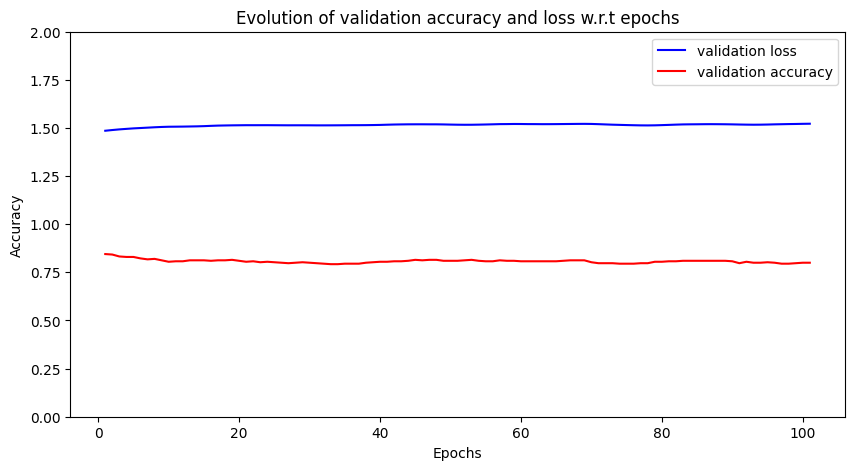

In [87]:
import matplotlib.pyplot as plt
#train_losses, train_scores, val_losses, val_scores
def plot_accuracy2(epoch_list, train_losses, val_scores):
    plt.figure(figsize = [10,5])
    plt.plot(epoch_list, train_losses, 'b', label = "validation loss")
    plt.plot(epoch_list, val_scores, 'r', label = "validation accuracy")
    plt.title("Evolution of validation accuracy and loss w.r.t epochs")
    plt.ylim([0.0, 2.0])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig('/content/drive/My Drive/GAT_cora_200_epoch.png')
    plt.show()


epoch_list = list(range(1, 102))
plot_accuracy2(epoch_list, loss_values, acc_values)

In [88]:
def run_transductive_experiment_cora(iters=100):
  losses = []
  scores = []
  for iter in range(iters):
    #features, labels, adj_mat = load_data(device=device)
    #idx = torch.randperm(len(labels)).to(device)
    #idx_test, idx_val, idx_train = idx[:1000], idx[1000:1500], idx[1500:]
    best_model, loss_values, acc_values, loss_test, acc_test = train_and_evaluate(GAT_cora, (features, adj_mat), labels, idx_train, idx_val, args['epochs'], args['patience'], False)
    # best_model,_ ,_ ,_ ,_ = train(model, ppi_train_params, verbose=False)
    # loss, score = evaluate(best_model, test_loader)
    losses.append(loss_test)
    scores.append(acc_test)
  losses = torch.tensor(losses)
  scores = torch.tensor(scores)
  # return (torch.std_mean(losses), torch.std_mean(scores))
  return losses, scores

In [82]:
losses_cora, scores_cora = run_transductive_experiment_cora(10)

Early stopping...
Best Val Loss: 1.4969, Best Val Acc: 0.8200
Optimization Finished!
Total time elapsed: 21.5873s
Loading 168th epoch
Test set results: loss 1.4983 accuracy 0.8290
Early stopping...
Best Val Loss: 1.5056, Best Val Acc: 0.8120
Optimization Finished!
Total time elapsed: 13.0155s
Loading 62th epoch
Test set results: loss 1.4992 accuracy 0.8180
Early stopping...
Best Val Loss: 1.5013, Best Val Acc: 0.8180
Optimization Finished!
Total time elapsed: 12.5604s
Loading 55th epoch
Test set results: loss 1.4931 accuracy 0.8230
Early stopping...
Best Val Loss: 1.5046, Best Val Acc: 0.8080
Optimization Finished!
Total time elapsed: 9.8877s
Loading 28th epoch
Test set results: loss 1.5071 accuracy 0.8110
Early stopping...
Best Val Loss: 1.5033, Best Val Acc: 0.8120
Optimization Finished!
Total time elapsed: 13.4593s
Loading 71th epoch
Test set results: loss 1.5093 accuracy 0.8230
Early stopping...
Best Val Loss: 1.5032, Best Val Acc: 0.8280
Optimization Finished!
Total time elapsed: 

In [89]:
losses_cora_2, scores_cora_2 = run_transductive_experiment_cora(10)

Early stopping...
Best Val Loss: 1.4908, Best Val Acc: 0.8425
Optimization Finished!
Total time elapsed: 7.6540s
Loading 1th epoch
Test set results: loss 1.4761 accuracy 0.8583
Early stopping...
Best Val Loss: 1.5007, Best Val Acc: 0.8325
Optimization Finished!
Total time elapsed: 7.6488s
Loading 1th epoch
Test set results: loss 1.4836 accuracy 0.8625
Early stopping...
Best Val Loss: 1.5030, Best Val Acc: 0.8400
Optimization Finished!
Total time elapsed: 10.6371s
Loading 39th epoch
Test set results: loss 1.5032 accuracy 0.8175
Optimization Finished!
Total time elapsed: 15.5065s
Loading 149th epoch
Test set results: loss 1.5019 accuracy 0.8267
Optimization Finished!
Total time elapsed: 15.8922s
Loading 125th epoch
Test set results: loss 1.5035 accuracy 0.8208
Optimization Finished!
Total time elapsed: 15.4911s
Loading 185th epoch
Test set results: loss 1.5052 accuracy 0.8183
Optimization Finished!
Total time elapsed: 16.5558s
Loading 126th epoch
Test set results: loss 1.4995 accuracy 0.

In [90]:
loss_std, loss_mean = torch.std_mean(losses_cora_2)
score_std, score_mean = torch.std_mean(scores_cora_2)

print(f'GAT test loss:\t\t{loss_mean:.4f} +/- {loss_std:.4f}')
print(f'GAT test accuracy: \t{score_mean:.4f} +/- {score_std:.4f}')

test loss:		1.4994 +/- 0.0108
test micro F1 score: 	0.8303 +/- 0.0166


In [83]:
loss_std, loss_mean = torch.std_mean(losses_cora)
score_std, score_mean = torch.std_mean(scores_cora)

print(f'GAT test loss:\t\t{loss_mean:.4f} +/- {loss_std:.4f}')
print(f'GAT test accuracy: \t{score_mean:.4f} +/- {score_std:.4f}')

test loss:		1.5011 +/- 0.0053
test micro F1 score: 	0.8240 +/- 0.0081


In [91]:
losses_cora_100, scores_cora_100 = run_transductive_experiment_cora(100)

Optimization Finished!
Total time elapsed: 16.1800s
Loading 165th epoch
Test set results: loss 1.4999 accuracy 0.8300
Optimization Finished!
Total time elapsed: 15.5838s
Loading 150th epoch
Test set results: loss 1.5006 accuracy 0.8258
Early stopping...
Best Val Loss: 1.5069, Best Val Acc: 0.8150
Optimization Finished!
Total time elapsed: 13.6452s
Loading 70th epoch
Test set results: loss 1.5001 accuracy 0.8208
Optimization Finished!
Total time elapsed: 15.4441s
Loading 139th epoch
Test set results: loss 1.5034 accuracy 0.8242
Early stopping...
Best Val Loss: 1.5054, Best Val Acc: 0.8150
Optimization Finished!
Total time elapsed: 14.0373s
Loading 79th epoch
Test set results: loss 1.5001 accuracy 0.8267
Early stopping...
Best Val Loss: 1.5100, Best Val Acc: 0.8150
Optimization Finished!
Total time elapsed: 11.3669s
Loading 47th epoch
Test set results: loss 1.5020 accuracy 0.8250
Optimization Finished!
Total time elapsed: 15.4568s
Loading 174th epoch
Test set results: loss 1.5013 accurac

In [93]:
loss_std_cora_100, loss_mean_cora_100 = torch.std_mean(losses_cora_100)
score_std_cora_100, score_mean_cora_100 = torch.std_mean(scores_cora_100)

print(f'GAT test loss:\t{loss_mean_cora_100:.4f} +/- {loss_std_cora_100:.4f}')
print(f'GAT test accuracy: \t{score_mean_cora_100:.4f} +/- {score_std_cora_100:.4f}')

test loss:	1.5047 +/- 0.0051
test accuracy: 	0.8258 +/- 0.0049
